In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#Reads data from Melbourne Housing and Poperty Sales of Melbourne City. Sources claim to be scrapped from domain.com
dataset1 = pd.read_csv("raw_data/PrimaryData.csv")
dataset2 = pd.read_csv("raw_data/SecondaryData.csv")

In [4]:
#Takes our two datasets and merges them together into one. Then looking at any Null values and deciding how to handle them. 
Merged_Data = pd.merge(dataset1,dataset2,how='outer')
Merged_Data.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price             7610
Method               0
SellerG              0
Date                 0
Distance             2
Postcode             2
Bedroom2         11686
Bathroom         11697
Car              12304
Landsize         16603
BuildingArea     31749
YearBuilt        28744
CouncilArea       6166
Lattitude        11308
Longtitude       11308
Regionname           4
Propertycount        4
KeyID            34857
dtype: int64

In [5]:
#Exploring the shape of our initial dataset. Output shows that our intial dataset has 53K rows. Our previous exploration into NaN values shows that a lot of values are missing for our data. 
Merged_Data.shape

(53253, 22)

In [6]:
#Dropping irrellevant columns that we think dont correlate to price. 
#We are doing this now to hopefully thing down the amount of potential NaN values in our dataset which we will remove in the next step.
# Also we will drop any duplicates. This narrows our dataset to 33K values. 
Data = Merged_Data.drop(["Date","Lattitude", "Suburb", "KeyID","Address", "Method", "SellerG","Postcode", "CouncilArea", "YearBuilt", "Propertycount"], axis = 1)
Data.drop_duplicates(inplace = True)
Data

,Rooms,Type,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,Longtitude,Regionname
0,2,h,1075000.0,3.0,2.0,1.0,0.0,NaN,92.0,145.00067,Northern Metropolitan
1,3,h,NaN,2.5,3.0,2.0,1.0,119.0,167.0,144.99990,Northern Metropolitan
2,3,u,1001000.0,3.0,3.0,2.0,1.0,NaN,NaN,144.99834,Northern Metropolitan
4,2,u,505000.0,3.0,2.0,1.0,1.0,0.0,38.0,145.00015,Northern Metropolitan
6,4,t,1525000.0,3.0,4.0,2.0,2.0,102.0,NaN,145.00066,Northern Metropolitan
...,...,...,...,...,...,...,...,...,...,...,...
53244,3,h,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,Western Metropolitan
53245,2,h,820000.0,7.0,2.0,1.0,0.0,211.0,NaN,144.88650,Western Metropolitan
53247,3,h,1100000.0,6.3,3.0,1.0,0.0,221.0,137.0,144.89159,Western Metropolitan
53249,4,h,NaN,7.0,4.0,1.0,2.0,476.0,NaN,144.88430,Western Metropolitan


In [7]:
#We want to drop any Not a number values from our dataset but doing so now will leave us with only 9K values to train our model off. 
# Let's look at where these NaN values are coming from again
Data.isnull().sum()

Rooms               0
Type                0
Price            6729
Distance            2
Bedroom2         7147
Bathroom         7156
Car              7658
Landsize        10731
BuildingArea    20028
Longtitude       6906
Regionname          4
dtype: int64

In [8]:
#Notice 20K values dont have a building area and 10K havent got a landsize. These are definitely correlative to price but we cant use them. 
# We could use the average, but for a dataset like ours the range is much to large and would give us a lot of inaccurate rows. 

#Data.drop(["BuildingArea"], axis='columns', inplace=True)
#Data.isnull().sum()


In [9]:
# Instead lets try and use K-means nearest neighbour method that will fill missing values based on similar rows in the dataset. 
from sklearn.impute import KNNImputer

Missing_Columns = ['Landsize', 'Bedroom2', 'Rooms', 'BuildingArea']
imputer = KNNImputer(n_neighbors=5)
DataSubset = Data[Missing_Columns]
Data_imputed = imputer.fit_transform(DataSubset)
Data_imputed = pd.DataFrame(Data_imputed, columns=Missing_Columns)
Data['BuildingArea'] = Data['BuildingArea'].fillna(Data_imputed['BuildingArea'])

In [10]:
#The good news is that we successfully recovered about 13 thousand values from the BuildingArea column, lets do the other important columns now too. 
Data.isnull().sum()

Rooms               0
Type                0
Price            6729
Distance            2
Bedroom2         7147
Bathroom         7156
Car              7658
Landsize        10731
BuildingArea     7336
Longtitude       6906
Regionname          4
dtype: int64

In [11]:
SimilarFeatures = ['Landsize', 'Bedroom2', 'Rooms', 'BuildingArea']
imputer = KNNImputer(n_neighbors=5)
DataSubset = Data[SimilarFeatures]
Data_imputed = imputer.fit_transform(DataSubset)
Data_imputed = pd.DataFrame(Data_imputed, columns=Missing_Columns)
Data['Landsize'] = Data['Landsize'].fillna(Data_imputed['Landsize'])
print(Data_imputed.head())

   Landsize  Bedroom2  Rooms  BuildingArea
0     839.4       2.0    2.0          92.0
1     119.0       3.0    3.0         167.0
2     814.0       3.0    3.0         311.2
3       0.0       2.0    2.0          38.0
4     102.0       4.0    4.0          75.0


In [12]:
# We recovered another 7k values in Landsize. 
Data.isnull().sum()

Rooms              0
Type               0
Price           6729
Distance           2
Bedroom2        7147
Bathroom        7156
Car             7658
Landsize        3885
BuildingArea    7336
Longtitude      6906
Regionname         4
dtype: int64

In [13]:
#Now let's drop the NaN values. By using the K-Nearest method to fill in some missing values we improved the volume of data to train our dataset on. 

Cleaned_data = Data.dropna()
Cleaned_data.shape

(16226, 11)

In [14]:
#We could encode the suburb into a binary format. probably a better way to do this but not sure. Location is surely correlated to price. Perhaps we should use distance to CBD instead?
Cleaned_data = pd.get_dummies(Cleaned_data, columns = ["Regionname"]) 

In [15]:
#Encoding the Type into a binary format. H = house, T = townhouse, U = unit  
Cleaned_data = pd.get_dummies(Cleaned_data, columns = ["Type"])

In [16]:
from sklearn.model_selection import train_test_split
X = Cleaned_data.drop(['Price'], axis = 1)
Y = Cleaned_data['Price']

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [18]:
#Joining the training data back together. 
train_data = X_train.join(Y_train)

<Axes: >

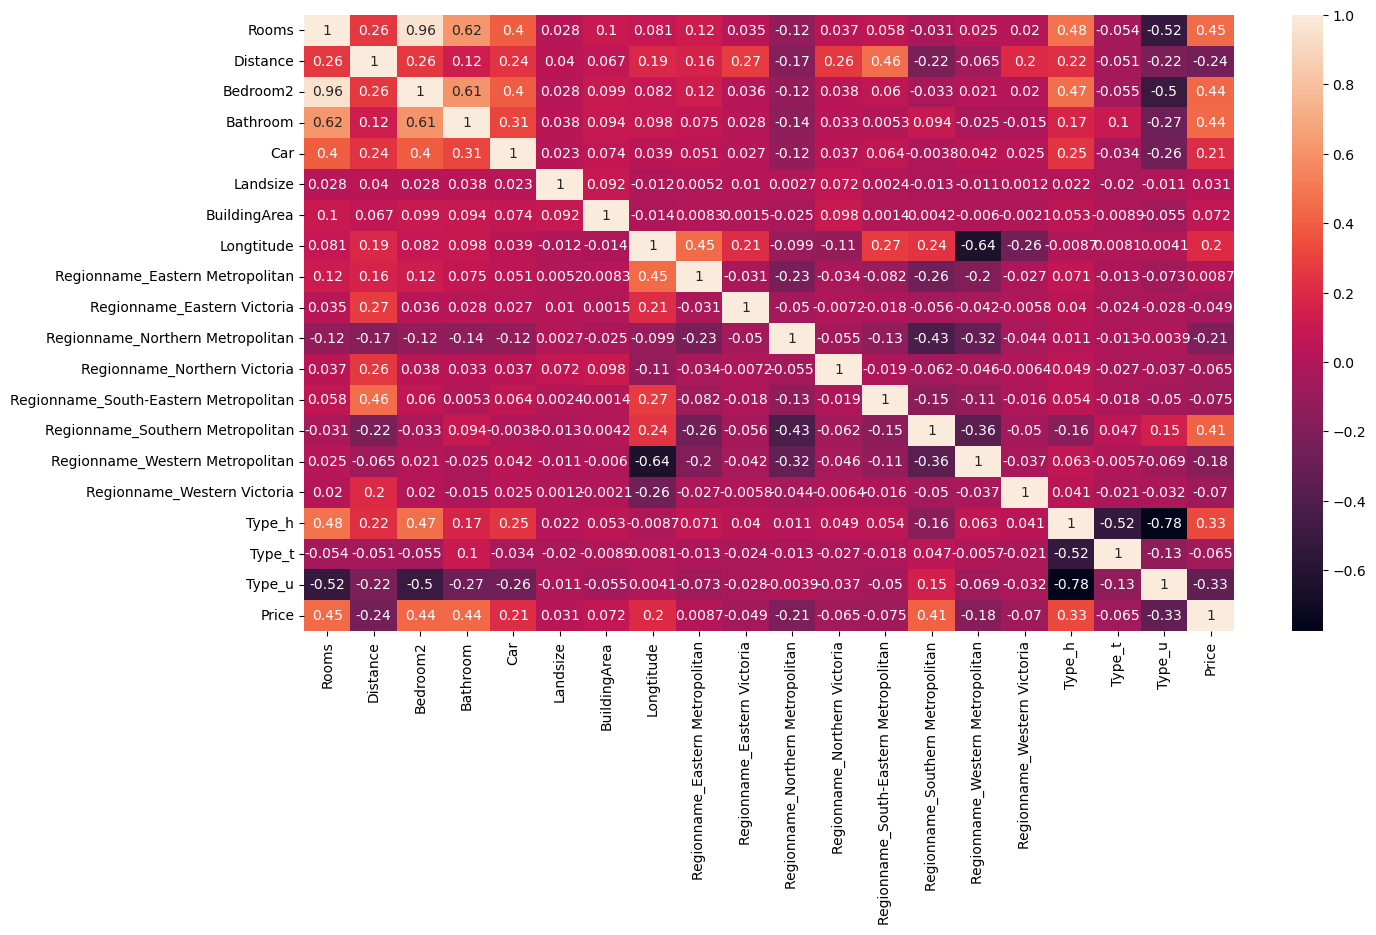

In [19]:
#Lets look at how different variables correlate to price. Seaborn heatmap is a great way to view this.   
plt.figure(figsize = (15,8))
sns.heatmap(train_data.corr(), annot=True)

array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

<Figure size 2500x1000 with 0 Axes>

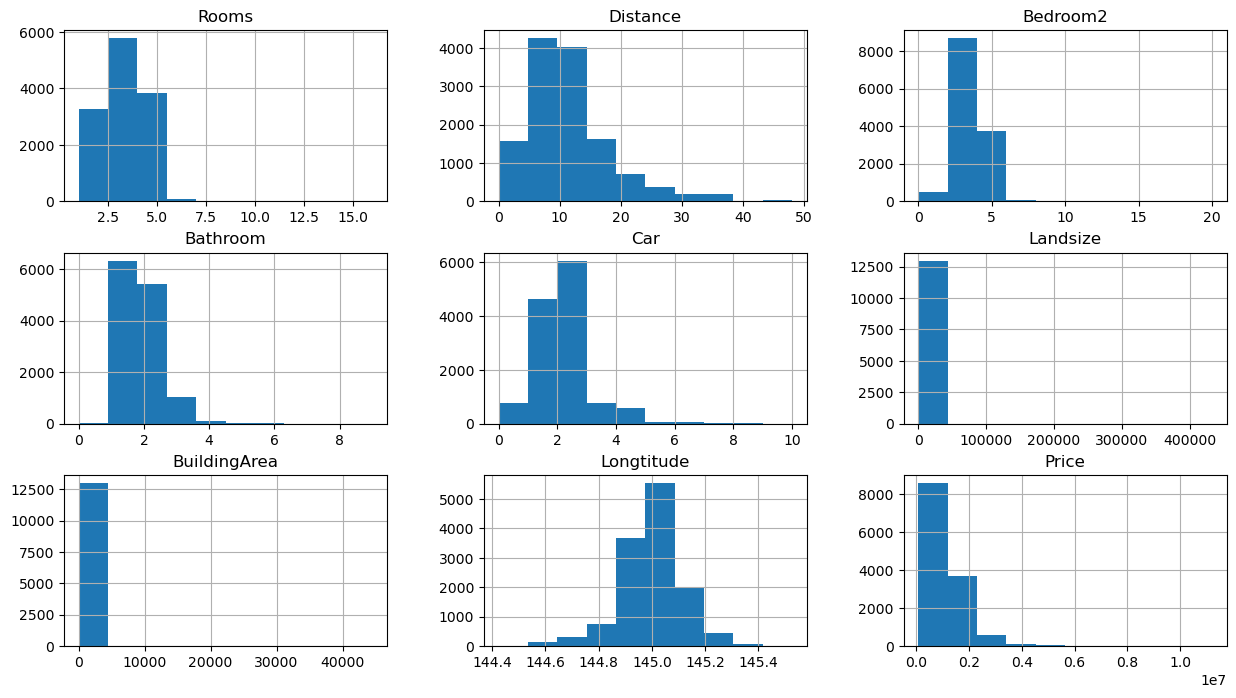

In [20]:
#Features are somewhat skewed, ideally we want a bell curve type distubtion 
plt.figure(figsize=(25,10))
train_data.hist(figsize=(15,8))

In [21]:
#Normalising data using logirithms. 
train_data['Rooms'] = np.log (train_data['Rooms']+1)
train_data['Distance'] = np.log (train_data['Distance']+1)
train_data['Price'] = np.log (train_data['Price']+1)
train_data['Bedroom2'] = np.log (train_data['Bedroom2']+1)
train_data['Landsize'] = np.log (train_data['Landsize']+1)
train_data['BuildingArea'] = np.log (train_data['BuildingArea']+1)
train_data['Longtitude'] = np.log (train_data['Longtitude']+1)
train_data['Car'] = np.log (train_data['Car']+1)
train_data['Bathroom'] = np.log (train_data['Bathroom']+1)




array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Bedroom2'}>],
       [<Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'Longtitude'}>,
        <Axes: title={'center': 'Price'}>]], dtype=object)

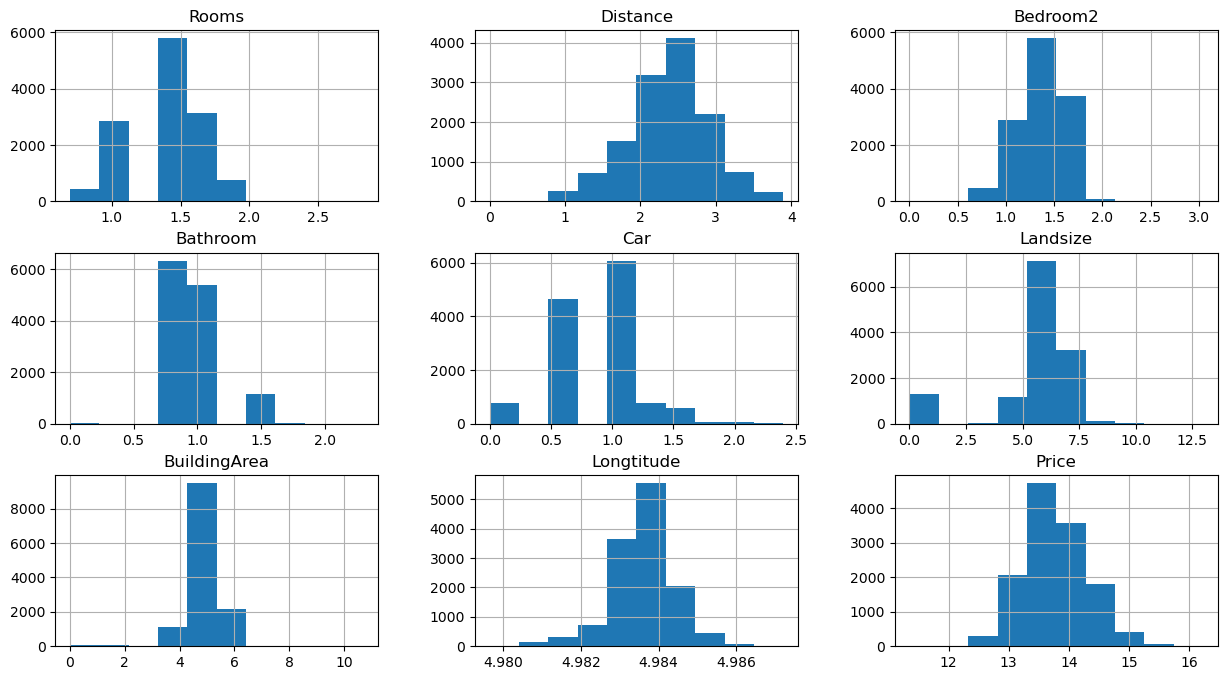

In [22]:
#Showing data after normalising with logarithms. 
train_data.hist(figsize=(15,8))

In [23]:
#Simple Linear Regression model, scaling our training data too. Then lastly fitting training data to line. 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
reg = LinearRegression()
scaler = StandardScaler()
X_train_s= scaler.fit_transform(X_train)
reg.fit(X_train_s,Y_train)

LinearRegression()

In [24]:
#Normalising our test data using logarithms. 
test_data = X_test.join(Y_test)

test_data['Rooms'] = np.log (test_data['Rooms']+1)
test_data['Distance'] = np.log (test_data['Distance']+1)
test_data['Price'] = np.log (test_data['Price']+1)
test_data['Bedroom2'] = np.log (test_data['Bedroom2']+1)
test_data['Landsize'] = np.log (test_data['Landsize']+1)
test_data['BuildingArea'] = np.log (test_data['BuildingArea']+1)
test_data['Landsize'] = np.log (test_data['Landsize']+1)
test_data['Car'] = np.log (test_data['Car']+1)
test_data['Bathroom'] = np.log (test_data['Bathroom']+1)

In [25]:
X_test_s = scaler.transform(X_test)

In [26]:
reg.score(X_test_s,Y_test)

0.6014825261115324

In [27]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, Y_train)

RandomForestRegressor()

In [28]:
forest.score(X_test_s,Y_test)

0.7865192284387889

In [29]:
from sklearn.model_selection import GridSearchCV

grid = {
    "n_estimators": [3,10,30],
    "max_features": [2,4,6,8],
}

grid_search = GridSearchCV(forest,grid, cv = 5,
                           return_train_score= True,
                           scoring="neg_mean_squared_error")

grid_search.fit(X_train_s, Y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 4, 6, 8],
                         'n_estimators': [3, 10, 30]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [30]:
best_forest = grid_search.best_estimator_
best_forest.score(X_test_s, Y_test)

0.7876753101946978